In [1]:
import sys, os
import serial
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import win32com.client
from astropy.io import fits
import threading
import nbimporter
from picoammeter_control import (
    send_cmd,
    query,
    init_cmds
)
from camera_control_ascom import (
    take_ramp,
    camera_init
)
sys.path.insert(0, os.path.abspath('.'))
sys.path.insert(0, os.path.abspath('filter_wheel_control'))
from filter_wheel_control.wheel_controller import (
    list_devices,
    open_device,
    get_position,
    get_position_count,
    set_position,
    close_device
)

In [2]:
"""init filter wheels to empty pos"""
# init filter wheels
def init_wheels():
    print("Finding filter wheel devices...")
    devices = list_devices()
    if not devices:
        print("No filter wheel devices found.")
        sys.exit(1)

    print("Found devices:")
    for idx, dev in enumerate(devices):
        print(f" [{idx}] {dev}")

    # init filter wheels to empty pos
    for i in range(len(devices)):
        handle = open_device(devices[i])
        max_pos = get_position_count(handle)
        print(max_pos)
        if max_pos > 1:
            set_position(handle, 1)
            if max_pos == 6:
                wheel6_port = i
            elif max_pos == 12:
                wheel12_port = i
        else:
            close_device(handle)
        # close_device(handle)

    return handle, wheel6_port, wheel12_port

def close_wheels():
    devices = list_devices()
    for i in range(len(devices)):
        handle = open_device(devices[i])
        close_device(handle)

init_wheels()
close_wheels()

Finding filter wheel devices...
Found devices:
 [0] COM5
 [1] COM7
 [2] COM4
-1
6
12


In [3]:
"""init camera"""
camera_init()

You selected: ASCOM.ASICamera2.Camera


KEITHLEY INSTRUMENTS INC.,MODEL 6485,4070587,C01   Jun 23 2010 12:22:00/A02  /H
relative std: 2.386570665126091e-11


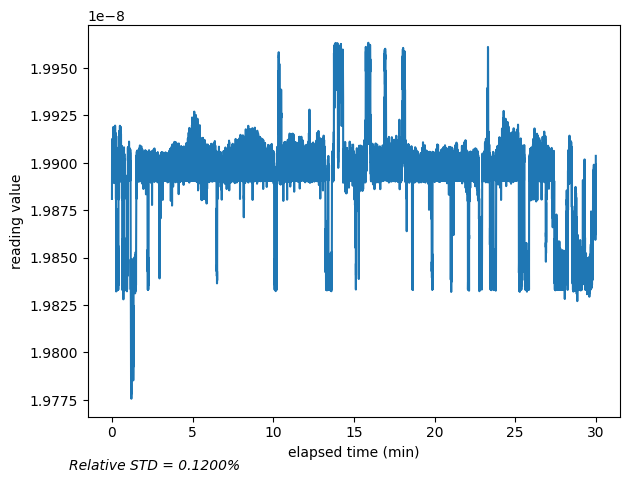

saved to path


In [23]:
""" to calculate picoammeter stability """
# Open serial connection
ser = serial.Serial(
    port='COM5',         # Replace with your actual port
    baudrate=9600,
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    timeout=2,
    xonxoff=False,
    rtscts=False,
    dsrdtr=False
)

init_cmds(ser)

read_time       = 30          # minutes
sample_interval = 0.004          # seconds between reads
start_time = time.time()
end_time   = start_time + read_time * 60
readings_1 = []
times_1    = []
while time.time() < end_time:
    time.sleep(sample_interval)
    current = query(ser, 'READ?')
    readings_1.append(current)
    times_1.append(time.time())

# Convert to NumPy arrays
readings = np.array(readings_1, dtype=float)
times    = np.array(times_1,    dtype=float)

mean_readings = np.mean(readings)
std_readings = np.std(readings)
rel_std = std_readings/mean_readings
print(f"relative std: {std_readings}")

elapsed = (times - times[0])/60.0
plt.plot(elapsed, readings)
plt.xlabel("elapsed time (min)")
plt.ylabel("reading value")
plt.subplots_adjust(bottom=0.15)
plt.figtext(0.25, 0.01,
            f"Relative STD = {rel_std:.4%}",
            ha="center", fontsize=10, fontstyle='italic')
plt.tight_layout()
plt.show()

import pandas as pd
df = pd.DataFrame({
    'time_min':       elapsed,
    'reading':        readings,
    'relative_std':   rel_std          # single value repeated
})
csv_path = f'picoam_readings_{read_time}_min.csv'
df.to_csv(csv_path, index=False)
print("saved to path")

ser.close()

In [4]:
"""helper functions for running camera and picoammeter simultaneously"""
def picoam_worker(ser, stop_event, readings_list, times_list, sample_interval=0.004):
    """
    Continuously query the picoammeter until stop_event is set.
    Appends readings and timestamps into the provided lists.
    """
    while not stop_event.is_set():
        time.sleep(sample_interval)
        raw = query(ser, 'READ?')
        current = float(raw)
        readings_list.append(current)
        times_list.append(time.time())

    ser.close()

def camera_with_picoam(cam_name, exp_low, exp_high, num_exp=10, num_frames=1, img_shape=(1000,1000),
              save_path=None, bit_depth=16, temp_setpoint=None, filter_change = False, handle=None, wheel6_port=None, wheel12_port=None):

    # runs take_ramp but records with picoammeter simultaneously
    stop_evt      = threading.Event()
    picoam_readings = []   # plain Python lists so we can append indefinitely
    picoam_times    = []

    picoam_thread = threading.Thread(
        target=picoam_worker,
        args=(ser, stop_evt, picoam_readings, picoam_times),
    )
    picoam_thread.start() # start collecting data with picoammeter

    if filter_change:
        nd_filters = [0, 0.5, 1.0, 2.0, 3.0, 4.0]
        for i in range(6):
            set_position(handle, i+1)
            print("taking img: ", i+1)
            exp_times, img_array, img_times = take_ramp(cam_name, exp_low, exp_high, num_exp, num_frames, img_shape, save_path+f"nd_{nd_filters[i]}", bit_depth, temp_setpoint)
        close_wheels()
    else:
        exp_times, img_array, img_times = take_ramp(cam_name, exp_low, exp_high, num_exp, num_frames, img_shape, save_path, bit_depth, temp_setpoint)

    stop_evt.set() # end picoammeter
    picoam_thread.join()
    picoam_readings = np.array(picoam_readings)
    picoam_times = np.array(picoam_times)
    matched_readings = np.interp(img_times, picoam_times, picoam_readings)
    exp_flat = np.repeat(exp_times, num_frames)
    return exp_flat, matched_readings, img_array, exp_times

Finding filter wheel devices...
Found devices:
 [0] COM5
 [1] COM7
 [2] COM4
-1
6
12

Camera connected: ASCOM.ASICamera2.Camera, Size: 6248x4176, Temperature: 0.00C
Taking frames at 0.00025000 seconds (exposure time 1/30)
camera offset: 0
Taking frames at 0.00032491 seconds (exposure time 2/30)
camera offset: 0
Taking frames at 0.00042228 seconds (exposure time 3/30)
camera offset: 0
Taking frames at 0.00054881 seconds (exposure time 4/30)
camera offset: 0
Taking frames at 0.00071327 seconds (exposure time 5/30)
camera offset: 0
Taking frames at 0.00092701 seconds (exposure time 6/30)
camera offset: 0
Taking frames at 0.00120479 seconds (exposure time 7/30)
camera offset: 0
Taking frames at 0.00156581 seconds (exposure time 8/30)
camera offset: 0
Taking frames at 0.00203502 seconds (exposure time 9/30)
camera offset: 0
Taking frames at 0.00264483 seconds (exposure time 10/30)
camera offset: 0
Taking frames at 0.00343737 seconds (exposure time 11/30)
camera offset: 0
Taking frames at 0.

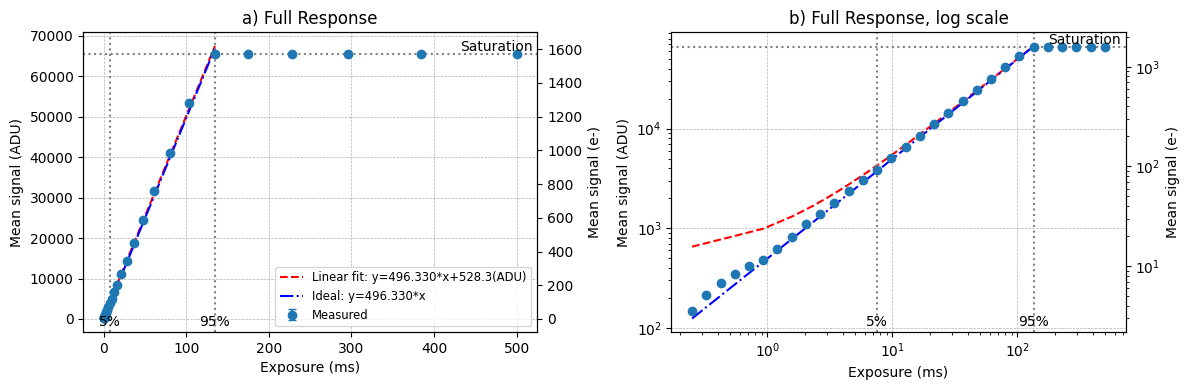

Data saved to exp_0.00025-0.5_linearity_data.csv
Figure saved to exp_0.00025-0.5_linearity_figure.png


In [42]:
"""Compares camera data vs picoammeter data, var exposure"""
handle, wheel6_port, wheel12_port = init_wheels()
# Open serial connection
ser = serial.Serial(
    port='COM5',         # Replace with your actual port
    baudrate=9600,
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    timeout=2,
    xonxoff=False,
    rtscts=False,
    dsrdtr=False
)
# init picoammeter
init_cmds(ser)

cam_name = "ASCOM.ASICamera2.Camera"
bit_depth = 16
num_exp = 30
num_frames = 5
exp_low = 0.00025
exp_high = 0.5
exp_flat, matched_readings, img_array, exp_times = camera_with_picoam(
        cam_name = cam_name,
        exp_low = exp_low,
        exp_high = exp_high,
        num_exp= num_exp,
        num_frames= num_frames,
        img_shape= (1000,1000),
        save_path= "C:/Users/Jonah/fits_imgs",
        bit_depth=bit_depth,
        filter_change = False,
        handle = handle,
        wheel6_port = wheel6_port,
        wheel12_port = wheel12_port
    )

# Compute per‐frame signal matrix of shape (num_exp, num_frames) directly from the 4D img_array
per_frame = img_array.mean(axis=(2,3))   # shape → (num_exp, num_frames)

# Compute mean ± 1σ across the num_frames for each exposure
mean_signal = per_frame.mean(axis=1)     # shape → (num_exp,)
std_signal  = per_frame.std(axis=1)      # shape → (num_exp,)

# Prepare your x‐axis: exposure time in ms
exp_ms = exp_times * 1e3

# Identify the linear regime
bit_max = 2**bit_depth - 1

min_percent = 0.05
max_percent = 0.95
# indices of exposures that are within min% and max% of full‐well
low_idx_arr = np.where(mean_signal >= min_percent * bit_max)[0]
high_idx_arr = np.where(mean_signal >= max_percent * bit_max)[0]
if low_idx_arr.size == 0 or high_idx_arr.size == 0:
    raise RuntimeError(f"Your data never reaches {min_percent*100:.0f}% or {max_percent*100:.0f}% of full well!")
low_idx = low_idx_arr[0]
high_idx = high_idx_arr[0]

threshold = 0.5 * bit_max
exp_50 = np.interp(threshold, mean_signal, exp_ms)
print(f"Exposure for 50% saturation: {exp_50:.3f} ms")


# for making graphs
x_percent = exp_ms[low_idx]
m, b = np.polyfit(
    exp_ms[low_idx : high_idx + 1],
    mean_signal[low_idx : high_idx + 1],
    1
)
"""
# for finding % change in exp time between readings
delta_exp_ms    = np.diff(exp_ms)           # length num_exp-1
delta_signal    = np.diff(mean_signal)      # length num_exp-1

# 2) Relative (percent) change in signal
percent_change  = delta_signal / mean_signal[:-1] * 100

# 3) Mid‐points for plotting
exp_mid_ms      = (exp_ms[:-1] + exp_ms[1:]) / 2
plt.figure()
plt.plot(exp_mid_ms, percent_change, 'o-')
plt.xscale('log')
plt.xlabel('Exposure (ms) [mid‐point]')
plt.ylabel('Percent Δ signal (%)')
plt.title('Percent Change in Signal Between Exposures')
plt.grid(True, ls='--', lw=0.5)
plt.tight_layout()
plt.show()"""

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# left: full range
ax1.errorbar(exp_ms, mean_signal, yerr=std_signal,
             fmt='o', capsize=3, label='Measured')
# plot fit line over linear regime
x_lin = np.linspace(exp_ms[0], exp_ms[high_idx], 200)
ax1.plot(x_lin, m*x_lin + b, 'r--', label=f'Linear fit: y={m:.3f}*x+{b:.1f}(ADU)')
# ideal line
ax1.plot(x_lin, m*x_lin, 'b-.', label=f'Ideal: y={m:.3f}*x')
# markers
ax1.axhline(bit_max,     ls=':', color='gray')
ax1.text(0.99, bit_max, 'Saturation', ha='right', va='bottom', transform=ax1.get_yaxis_transform())
ax1.axvline(x_percent,         ls=':', color='gray')
ax1.text(x_percent, 0.01, f'{min_percent*100:.0f}%', va='bottom', ha='center', transform=ax1.get_xaxis_transform())
ax1.axvline(exp_ms[high_idx], ls=':', color='gray')
ax1.text(exp_ms[high_idx], 0.01, f'{max_percent*100:.0f}%', va='bottom', ha='center', transform=ax1.get_xaxis_transform())
# ax1.set_xscale('log')
ax1.set_xlabel('Exposure (ms)')
ax1.set_ylabel('Mean signal (ADU)')
ax1.set_title('a) Full Response')
ax1.legend(fontsize='small')
e_per_adu = .024 # for HIGH gain mode only!
ax4 = ax1.twinx()
low, high = ax1.get_ylim()
ax4.set_ylim(low*e_per_adu, high*e_per_adu)
ax4.set_ylabel('Mean signal (e-)')

"""
# for zoom in on 0–x_percent
mask_percent = exp_ms <= x_percent
ax3.errorbar(exp_ms[mask_percent], mean_signal[mask_percent],
             yerr=std_signal[mask_percent],
             fmt='o', capsize=3)
# show the linear‐fit there too (through origin)
x_zoom = np.linspace(0, x_percent, 100)
ax3.plot(x_zoom, m*x_zoom + b, 'r--')
ax3.plot(x_zoom, m*x_zoom, 'b-.')
ax3.set_xlim(0, x_percent*1.05)  # a bit of padding
ax3.set_xscale('linear')
ax3.set_yscale('linear')
ax3.set_xlabel('Exposure (ms)')
ax3.set_title(f'b) 0-{min_percent*100:.0f}% Region')
ax6 = ax3.twinx()
low, high = ax3.get_ylim()
ax6.set_ylim(low*e_per_adu, high*e_per_adu)
ax6.set_ylabel('Mean signal (e-)')
ax6.set_yscale('linear')
"""

# left: full range
ax2.errorbar(exp_ms, mean_signal, yerr=std_signal,
             fmt='o', capsize=3, label='Measured')
# plot fit line over linear regime
x_lin = np.linspace(exp_ms[0], exp_ms[high_idx], 200)
ax2.plot(x_lin, m*x_lin + b, 'r--', label=f'Linear fit: y={m:.3f}*x+{b:.1f}(ADU)')
# ideal line
ax2.plot(x_lin, m*x_lin, 'b-.', label=f'Ideal: y={m:.3f}*x')
# markers
ax2.axhline(bit_max,     ls=':', color='gray')
ax2.text(0.99, bit_max, 'Saturation', ha='right', va='bottom', transform=ax2.get_yaxis_transform())
ax2.axvline(x_percent,         ls=':', color='gray')
ax2.text(x_percent, 0.01, f'{min_percent*100:.0f}%', va='bottom', ha='center', transform=ax2.get_xaxis_transform())
ax2.axvline(exp_ms[high_idx], ls=':', color='gray')
ax2.text(exp_ms[high_idx], 0.01, f'{max_percent*100:.0f}%', va='bottom', ha='center', transform=ax2.get_xaxis_transform())
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Exposure (ms)')
ax2.set_ylabel('Mean signal (ADU)')
ax2.set_title('b) Full Response, log scale')
ax5 = ax2.twinx()
low, high = ax2.get_ylim()
ax5.set_ylim(low*e_per_adu, high*e_per_adu)
ax5.set_ylabel('Mean signal (e-)')
ax5.set_yscale('log')

ax2.grid(True, ls='--', lw=0.5)
ax1.grid(True, ls='--', lw=0.5)
# ax3.grid(True, ls='--', lw=0.5)
plt.tight_layout()
plt.show()

# for saving data
df = pd.DataFrame({
    'exposure_ms':  exp_ms,
    'mean_ADU':     mean_signal,
    'std_ADU':      std_signal
})
path_base = f"exp_{exp_low}-{exp_high}_linearity"
csv_path = path_base+"_data.csv"
df.to_csv(csv_path, index=False)
print(f"Data saved to {csv_path}")

# for saving graphs
fig_path = path_base+"_figure.png"
fig.savefig(fig_path, dpi=300)
print(f"Figure saved to {fig_path}")

In [23]:
"""Gain calculator"""
def capture_frame(camera, exposure_ms, is_dark=False):
    """
    Capture a single frame:
     - is_dark=False → Light frame (flat)
     - is_dark=True  → Dark frame
    """
    # ASCOM expects seconds, not ms
    exposure_s = exposure_ms / 1000.0
    # LightFrame=True for a flat, False for a dark
    light = not is_dark
    camera.StartExposure(exposure_s, light)

    while not camera.ImageReady:
        time.sleep(0.01)
    print("image returned")
    return np.array(camera.ImageArray, dtype=float)


# --- Gain calculation via flat/dark method ---
def calculate_gain(camera, exposure_ms, n_frames=10):
    print("starting calculation")
    """
    Calculate e-/ADU gain using flat and dark frames.

    Steps:
    1. Capture n flat frames under uniform illumination.
    2. Capture n dark frames with shutter closed.
    3. Compute mean and variance of flats and darks.
    4. Gain = (mean_flat - mean_dark) / (var_flat - var_dark)

    Returns:
    - gain_e_per_adu: measured gain in electrons per ADU
    - stats: dict with means and variances
    """
    # Capture flats
    flats = [capture_frame(camera, exposure_ms, is_dark=False)
         for _ in range(n_frames)]
    flats = np.stack(flats)
    print("flats collected")
    # Capture darks
    print("close shutter!")
    time.sleep(10)
    darks = [capture_frame(camera, exposure_ms, is_dark=True)
         for _ in range(n_frames)]
    darks = np.stack(darks)
    print("darks collected")
    print("open shutter!")
    # Compute statistics
    mean_flat = np.mean(flats)
    var_flat = np.var(flats, ddof=1)
    mean_dark = np.mean(darks)
    var_dark = np.var(darks, ddof=1)
    print("calculations done")
    # Avoid division by zero
    diff_var = var_flat - var_dark
    if diff_var <= 0:
        raise ValueError("Variance difference flat-dark must be positive")

    # Calculate gain
    gain_e_per_adu = (mean_flat - mean_dark) / diff_var
    print("gain calculated")
    stats = {
        'mean_flat': mean_flat,
        'var_flat': var_flat,
        'mean_dark': mean_dark,
        'var_dark': var_dark
    }
    print("returning results")
    return gain_e_per_adu, stats

camera_init()
camera = win32com.client.Dispatch(cam_name)
camera.Connected = True
# Exposure for calibration (ms)
exposure_time = .25

# Calculate gain
gain, stats = calculate_gain(camera, exposure_time, n_frames=20)
print(f"Measured gain: {gain:.5f} e-/ADU")
print(f"Flat mean: {stats['mean_flat']}, Flat var: {stats['var_flat']:.1f}")
print(f"Dark mean: {stats['mean_dark']:}, Dark var: {stats['var_dark']:.1f}")

camera.Connected = False
"""
results
High gain = .024 e-/ADU
Middle gain = .245 e-/ADU
Low gain = .739 e-/ADU
"""

You selected: ASCOM.ASICamera2.Camera
starting calculation
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
flats collected
close shutter!
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
image returned
darks collected
open shutter!
calculations done
gain calculated
returning results
Measured gain: 0.24575 e-/ADU
Flat mean: 508.48473542759734, Flat var: 67.5
Dark mean: 502.94219390243194, Dark var: 45.0


'\nresults\nHigh gain = .024 e-/ADU\nMedium gain =  e-/ADU\nLow gain = .739 e-/ADU\n'